In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import clear_output
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding an observation."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class ConvMixer_LSTM_VAE(tf.keras.Model):

    def __init__(self, filters=32, depth=2, kernel_size=3, patch_size=8,  num_classes=2, activation = 'gelu'):
        super(ConvMixer_LSTM_VAE, self).__init__()

        self.conv_stem = keras.Sequential([
                layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size),
                layers.Activation(activation),
                layers.BatchNormalization()])
        
        self.depth_conv1 = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")
        self.add1 = layers.Add()
        self.conv1 = keras.Sequential([
                layers.Conv2D(filters*2, kernel_size=1),
                layers.Activation(activation),
                layers.BatchNormalization(), 
                layers.MaxPooling2D((3,3))])
            
        self.depth_conv2 = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")
        self.add2 = layers.Add()
        self.conv2 = keras.Sequential([
                layers.Conv2D(filters*4, kernel_size=1),
                layers.Activation(activation),
                layers.BatchNormalization(), 
                layers.GlobalAveragePooling2D(), 
                layers.Dense(h_dim, activation=activation)])

        
        self.lstm = tf.keras.layers.LSTM(h_dim, return_state=True, return_sequences=False, stateful=False)
        self.lstm.get_initial_state = self.get_initial_state
        
        self.reconstruction_model = self.get_decoder()
        self.q_values = tf.keras.layers.Dense(2)    
    

        
    def get_decoder(self, latent_dim = 2, n = 10, f = 16):
        
        latent_inputs = keras.Input(shape=(h_dim,))
        z_mean = layers.Dense(latent_dim, name="z_mean")(latent_inputs)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(latent_inputs)
        z = Sampling()([z_mean, z_log_var])
        
        x = layers.Dense(n * n * f, activation="relu")(z)
        x = layers.Reshape((n, n, f))(x)
        x = layers.Conv2DTranspose(f, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(f//2, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(f//4, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        return keras.Model(latent_inputs, [decoder_outputs, z_mean, z_log_var], name="decoder")
    
    def activation_block(x):
        x = layers.Activation("gelu")
        return layers.BatchNormalization()

    def conv_stem(x, filters: int, patch_size: int):
        x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)
        return activation_block()

    
    
    def get_initial_state(self, inputs):
        return self.lstm_initial_state
    
    def call(self, images, lstm_states, training=True):
        x0 = self.conv_stem(images, training=training)
        
        x = self.depth_conv1(x0)
        x = self.add1([x0,x])
        x0 = self.conv1(x, training=training)

        x = self.depth_conv2(x0)
        x = self.add2([x0,x])
        x = self.conv2(x, training=training)
        
        self.lstm_initial_state = lstm_states
        x = tf.keras.backend.expand_dims(x,axis=1)
        x, hidden_state, cell_state = self.lstm(x)
        q_values = self.q_values(x)
        
        if training:
            reconstructed_images, z_mean, z_log_var = self.reconstruction_model(x)
            return q_values, reconstructed_images, z_mean, z_log_var 
        else:
            return q_values, hidden_state, cell_state
        
        
h_dim = 64
model = ConvMixer_LSTM_VAE()
h = [np.ones((1, h_dim)).astype('float32'), np.ones((1, h_dim)).astype('float32')]
with tf.GradientTape() as tape:
    x = model(images = np.ones((1, 80, 80, 1)).astype('float32'), lstm_states = h)
    grads = tape.gradient(x[0], model.trainable_variables)
model.summary()

Model: "conv_mixer_lstm_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d (DepthwiseC multiple                  320       
_________________________________________________________________
add (Add)                    multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (1, 3, 3, 64)             2368      
_________________________________________________________________
depthwise_conv2d_1 (Depthwis multiple                  640       
_________________________________________________________________
add_1 (Add)                  multiple                  0         
_________________________________________________________________
sequential_2 (Sequential)    (1, 64)                   17088     
_________________________________________________________________
lstm (LSTM)                  multiple          

In [3]:
class dqn_agent():
    def __init__(self, lr=0.00025, batch_size=256):     
        
        self.num_actions = 2
        self.model = ConvMixer_LSTM_VAE()
        self.model_target = ConvMixer_LSTM_VAE()
        self.optimizer = keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
        self.loss_function = keras.losses.Huber()
        self.gamma = 0.95
        
        self.batch_size = batch_size
        self.memory = self.ReplayMemory(250_000)
        
        
        self.step = 0
        self.update_step_interval = 4
        self.init_random_steps = 10_000
        self.update_target_network = 10_000
        
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        epsilon_greedy_steps = 200_000.0
        
        self.epsilon_decay_step = self.epsilon / epsilon_greedy_steps
        
    class ReplayMemory(object):
        
        def __init__(self, capacity):
            self.idx = 0
            self.capacity = capacity
            self.is_full = False
            self.memory = {'state':np.zeros((capacity, 80,80,1), dtype=np.float32),
                           'hidden_state': np.zeros((capacity, h_dim)).astype('float32'),
                           'lstm_cell_state': np.zeros((capacity, h_dim)).astype('float32'),
                           'Action':np.zeros((capacity), dtype=int),
                           'reward':np.zeros((capacity), dtype=np.float32),
                           'done':np.zeros((capacity), dtype=bool),
                           'next_state_ind': np.zeros((capacity), dtype=int)}
    
        def push_episode(self, args):
            i,j = self.idx, min(self.capacity, self.idx+len(args[0]))
            for ind, k in enumerate(self.memory.keys()):
                if k != 'next_state_ind':
                    self.memory[k][i:j] = args[ind][:(j-i)]
            
            next_state_ind = np.arange(i,j)
            rewards = self.memory['reward'][i:j]
            for idx in range(j-i-5):
                td = 5
                while abs(rewards[idx]) > abs(rewards[idx+td]):
                    td-=1
                next_state_ind[idx]+=td
                
            self.memory['next_state_ind'][i:j] = next_state_ind
            
            self.idx +=  len(args[0])
            if self.idx >= self.capacity:
                self.idx=0
                self.is_full = True

        def sample(self, batch_size):
            sample_idx = np.random.choice(self.__len__(), batch_size, replace=False) 
            sample = [self.memory[k][sample_idx] for k in self.memory.keys() if k != 'next_state_ind']
            next_state_ind = self.memory['next_state_ind'][sample_idx]
            sample.append(self.memory['state'][next_state_ind])
            sample.append(self.memory['hidden_state'][next_state_ind])
            sample.append(self.memory['lstm_cell_state'][next_state_ind])
            return sample

        def __len__(self):
            return self.capacity-5 if self.is_full else self.idx
    
    def push_episode(self, args):
        self.memory.push_episode(args)
        
    def sample_training_batch(self):
        return self.memory.sample(self.batch_size)

    
    @tf.function
    def act(self, state, h, c):
        q, h, c = self.model(state, [h, c], training=False)
        return tf.argmax(q[0]), h, c
    
    def select_action(self, state, h, c):
        self.step+=1
        self.epsilon = max(self.epsilon - self.epsilon_decay_step, self.min_epsilon)        
        
        action, h, c = self.act(state, h, c)
        action, h, c = action.numpy(), h.numpy(), c.numpy()
        if self.epsilon > np.random.rand(1)[0]:
            action = np.random.choice(self.num_actions)
        return action, h, c
    


    @tf.function
    def train(self, state, state_h, state_c, action, reward, 
              next_state, next_state_h, next_state_c, done):

        future_actions, _, _ = self.model(next_state, [next_state_h, next_state_c], training=False)
        future_actions = tf.argmax(future_actions, axis=1) 
        
        future_rewards, _, _ = self.model_target(next_state, [next_state_h, next_state_c], training=False)
        future_rewards = tf.reduce_sum(tf.multiply(future_rewards, tf.one_hot(future_actions, self.num_actions)), axis=1)
        
        future_rewards*= (float(1.0) - done) 
        target_q_values = reward + self.gamma * future_rewards

        masks = tf.one_hot(action, self.num_actions)
        with tf.GradientTape() as tape:
            q_values, reconstructed_images, z_mean, z_log_var = self.model(state, [state_h, state_c])
            q_values = tf.reduce_sum(tf.multiply(q_values, masks), axis=-1)
            q_loss = self.loss_function(q_values, target_q_values)

            reconstruction_loss = tf.reduce_mean(
               tf.reduce_sum(keras.losses.binary_crossentropy(next_state, reconstructed_images), axis=(1, 2)))

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = q_loss + 0.0003*(reconstruction_loss + kl_loss)

            
        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return total_loss
        
    def train_step(self):
        loss = 0
        if self.step % self.update_step_interval == 0 and self.step >= self.init_random_steps:
            state, state_h, state_c, action, reward, done,\
                        next_state, next_state_h, next_state_c= self.sample_training_batch()
                
            loss = self.train(state, state_h, state_c, action, reward,
                              next_state, next_state_h, next_state_c, done.astype('float32')).numpy()

            if self.step % self.update_target_network == 0:
                self.model_target(state, [state_h, state_c], training=False)
                self.model_target.set_weights(self.model.get_weights())
        return loss

In [4]:
def discounted_rewards(rewards, discount_rate = 0.97):
    for i in reversed(range(len(rewards)-1)):
        if rewards[i] == 0: 
            rewards[i] += discount_rate* rewards[i+1]
    return np.asarray(rewards).astype(np.float32)

#From Andrej Pong from Pixels blog: http://karpathy.github.io/2016/05/31/rl/
def prepro(I):
    I = I[35:195:2,::2, 0] # crop and downsample by factor of 2
    I[(I == 144) | (I == 109)] = 0 # erase background
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.expand_dims([I], axis=-1).astype(np.float32)

def progress(num_steps, reward, loss):
    n_steps.append(num_steps)
    running_rewards.append(0.98 * running_rewards[-1] + 0.02 * reward)
    if loss < 0.05:
        losses.append(loss)
    else:
        losses.append(0.05)

    clear_output(wait=True) 
    figure, axis = plt.subplots(1, 2, sharex=True, figsize=(16,4))
    axis[0].plot(n_steps, running_rewards)
    axis[0].set_title("Reward - 50 Episode Running Average", fontsize=14)
    axis[0].set_xlabel('# environment steps', fontsize=12)
    axis[1].plot(n_steps, losses)
    axis[1].set_title("Loss", fontsize=14)
    axis[1].set_xlabel('# environment steps', fontsize=12)
    plt.show()
    
def visualize_vae_output(obs, lstm_state, next_obs):
    figure, axis = plt.subplots(1, 2, sharex=True, figsize=(16,8))
    axis[0].imshow(next_obs)
    x = agent.model(obs, lstm_state)[1][0].numpy()
    axis[1].imshow(x)
    plt.show()

In [5]:
env = gym.make("PongDeterministic-v4")
agent = dqn_agent()
running_rewards, losses, n_steps = [-21],[0], [0]
step = 0

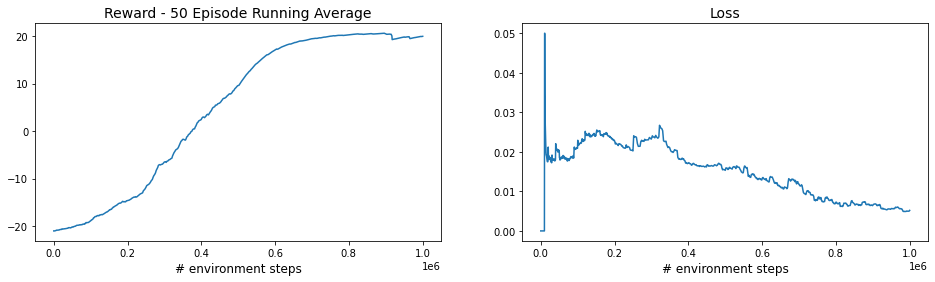

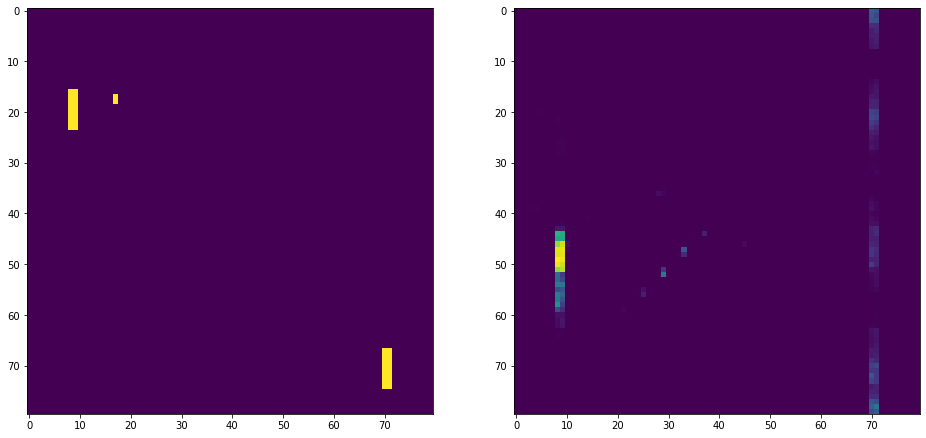

8.505000093951821 1637 0.005195479593128785
n_games: 687  n_steps: 1000464 running reward: 19.93 episode_reward 21.0 epsilon 0.0, actions [693 944]
!!!!!!!!!!


In [6]:
while step < 1.0e+6:
    done = False
    total_reward = 0
    obs =  prepro(env.reset())
    h, c = np.ones((1, h_dim)).astype('float32'), np.ones((1, h_dim)).astype('float32')
    eps_state, eps_h, eps_c, eps_action, eps_reward, eps_done = [],[],[],[], [],[]
    total_loss = 0 
    n = 0
    while not done:
        env.render()
        eps_state.append(obs[0])
        eps_h.append(h[0])
        eps_c.append(c[0])


        action, h, c = agent.select_action(obs, h, c)
        screen, reward, done, _ = env.step(action+2)
        if not done:
            screen, r, done, _ = env.step(action+2)
            reward+=r
        
        obs =  prepro(screen)
        
        eps_action.append(action) 
        eps_reward.append(reward)
        eps_done.append(done)
        
        total_loss+=agent.train_step()
        n+=1
        total_reward+=reward
        step+=1
    

    
    eps_reward = discounted_rewards(np.array(eps_reward))
    agent.push_episode([np.array(eps_state), np.array(eps_h), np.array(eps_c),
                        np.array(eps_action), eps_reward, np.array(eps_done)])
    
    progress(step, total_reward, total_loss/n)
    
    state, state_h, state_c, _, _, _, next_state, _, _= agent.sample_training_batch()
    visualize_vae_output(state[0:1], [state_h[0:1], state_c[0:1]], next_state[0])
    
    print(total_loss, n, total_loss/n)
    template = "n_games: {}  n_steps: {} running reward: {:.2f} episode_reward {} epsilon {}, actions {}"
    print(template.format(len(running_rewards), step, running_rewards[-1], total_reward, agent.epsilon, np.bincount(eps_action)))
    if total_reward > 0:
        print('!'*10)
        if running_rewards[-1] > 10.0:
            agent.epsilon = 0.0
            agent.min_epsilon = 0.0
            


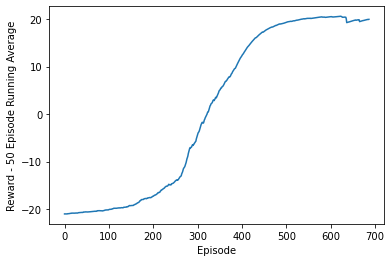

In [8]:
plt.clf()
plt.xlabel('Episode')
plt.ylabel('Reward - 50 Episode Running Average')
plt.plot(np.array(running_rewards))